Train shape: (1200, 81)
Test shape: (260, 80)


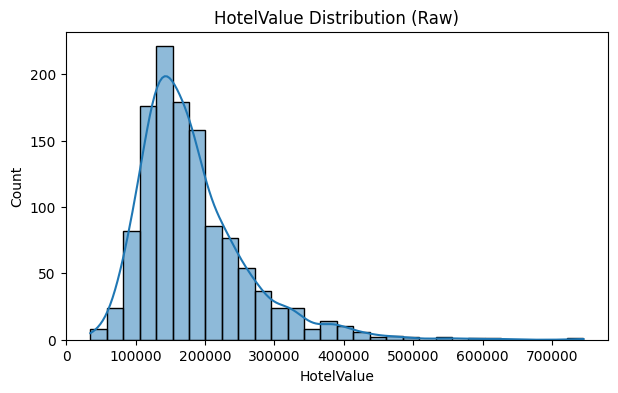

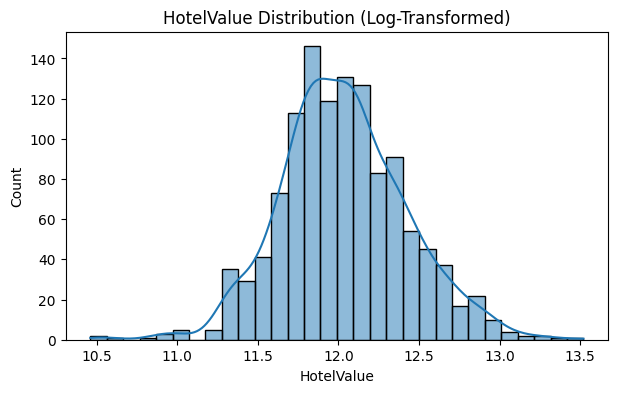

In [85]:
# === Basic Imports (always start here!) ===
import os, random, gc
import numpy as np
import pandas as pd  # <- THIS must come before data loading!
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# === File Paths ===
TRAIN_PATH = "/kaggle/input/Hotel-Property-Value-Dataset/train.csv"
TEST_PATH  = "/kaggle/input/Hotel-Property-Value-Dataset/test.csv"

# === Load Data ===
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Target Distribution (skewness & log transform effect)
plt.figure(figsize=(7, 4))
sns.histplot(train['HotelValue'], bins=30, kde=True)
plt.title("HotelValue Distribution (Raw)")
plt.show()
plt.figure(figsize=(7, 4))
sns.histplot(np.log1p(train['HotelValue']), bins=30, kde=True)
plt.title("HotelValue Distribution (Log-Transformed)")
plt.show()


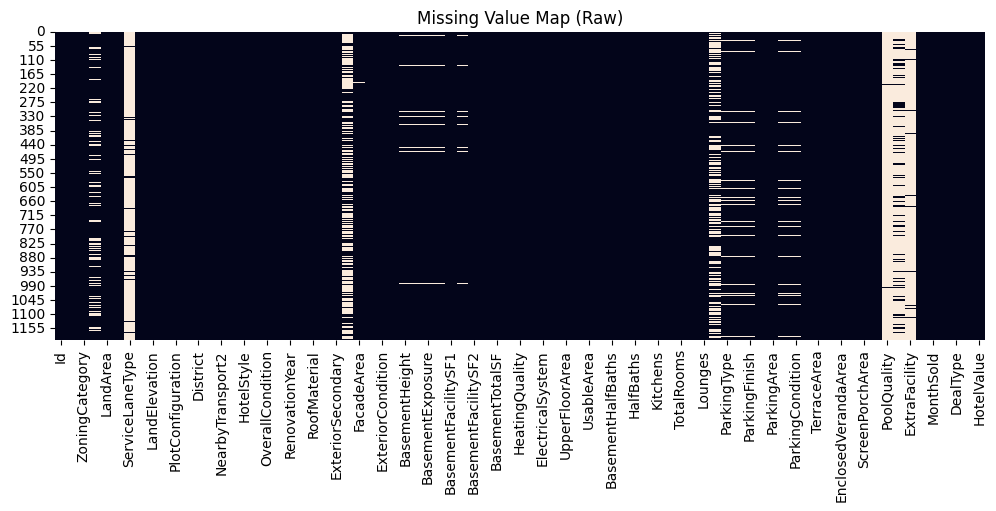

Train shape after drop duplicates: (1200, 81)
Test shape after drop duplicates: (260, 80)

Null value percentages (training):
 Id                   0.000000
PropertyClass        0.000000
ZoningCategory       0.000000
RoadAccessLength    18.583333
LandArea             0.000000
                      ...    
MonthSold            0.000000
YearSold             0.000000
DealType             0.000000
DealCondition        0.000000
HotelValue           0.000000
Length: 81, dtype: float64

Columns with null values (training):
 RoadAccessLength           18.583333
ServiceLaneType            93.750000
FacadeType                 58.500000
FacadeArea                  0.583333
BasementHeight              2.416667
BasementCondition           2.416667
BasementExposure            2.500000
BasementFacilityType1       2.416667
BasementFacilityType2       2.416667
ElectricalSystem            0.083333
LoungeQuality              46.666667
ParkingType                 5.416667
ParkingConstructionYear     5.416

In [86]:
# Visualize % missingness (heatmap style)
plt.figure(figsize=(12,4))
sns.heatmap(train.isnull(), cbar=False)
plt.title("Missing Value Map (Raw)")
plt.show()

# === Check for Duplicates ===
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

print("Train shape after drop duplicates:", train.shape)
print("Test shape after drop duplicates:", test.shape)


# === Missing Values ===
null_value_percentages=(train.isna().sum()/train.shape[0])*100
print("\nNull value percentages (training):\n", null_value_percentages)

columns_with_null_values = null_value_percentages[null_value_percentages>0]
print("\nColumns with null values (training):\n",columns_with_null_values)


null_value_percentages_test=(test.isna().sum()/test.shape[0])*100
print("\nNull value percentages (test):\n", null_value_percentages_test)

columns_with_null_values_test = null_value_percentages_test[null_value_percentages_test>0]
print("\nColumns with null values (test):\n",columns_with_null_values_test)

Here we have divided the columns based on the percentages of null values into the following categories:
* Columns with very less null values (0-1%)
* Columns with moderate amount of null values (1-5%)
* Columns with a lot of null values (>5%)

### Null Value Stuff

In [87]:
#=== Dropping Columns with lot of null values ===
columns_to_drop = null_value_percentages[null_value_percentages>5].index
print(columns_to_drop)
train.drop(columns=columns_to_drop, inplace=True)

columns_to_drop_test = null_value_percentages_test[null_value_percentages_test>5].index
test.drop(columns=columns_to_drop_test, inplace=True)

Index(['RoadAccessLength', 'ServiceLaneType', 'FacadeType', 'LoungeQuality',
       'ParkingType', 'ParkingConstructionYear', 'ParkingFinish',
       'ParkingQuality', 'ParkingCondition', 'PoolQuality', 'BoundaryFence',
       'ExtraFacility'],
      dtype='object')


In [88]:
#=== Checking Columns with moderate amount of null values ===
moderate_null_cols = null_value_percentages[(null_value_percentages > 1) & (null_value_percentages <= 5)].index
moderate_null_cols_test = null_value_percentages_test[(null_value_percentages_test > 1) & (null_value_percentages_test <= 5)].index

print("training data:",moderate_null_cols)
print("testing data:",moderate_null_cols_test)

print("\n")

for column in moderate_null_cols:
    if train[column].dtype == 'object':
        print(f"CATEGORICAL: {column}")
        print(train[column].value_counts(dropna=False))
    else:
        missing_count = train[column].isna().sum()
        print(f"NUMERIC: {column}")
        print(train[column].describe())
        print(f"Missing values: {missing_count}")
        
print("-" * 50)
for column in moderate_null_cols_test:
    if test[column].dtype == 'object':
        print(f"CATEGORICAL: {column}")
        print(test[column].value_counts(dropna=False))
    else:
        missing_count = test[column].isna().sum()
        print(f"NUMERIC: {column}")
        print(test[column].describe())
        print(f"Missing values: {missing_count}")

training data: Index(['BasementHeight', 'BasementCondition', 'BasementExposure',
       'BasementFacilityType1', 'BasementFacilityType2'],
      dtype='object')
testing data: Index(['BasementHeight', 'BasementCondition', 'BasementExposure',
       'BasementFacilityType1', 'BasementFacilityType2'],
      dtype='object')


CATEGORICAL: BasementHeight
BasementHeight
TA     530
Gd     508
Ex     103
Fa      30
NaN     29
Name: count, dtype: int64
CATEGORICAL: BasementCondition
BasementCondition
TA     1072
Gd       59
Fa       39
NaN      29
Po        1
Name: count, dtype: int64
CATEGORICAL: BasementExposure
BasementExposure
No     786
Av     181
Gd     107
Mn      96
NaN     30
Name: count, dtype: int64
CATEGORICAL: BasementFacilityType1
BasementFacilityType1
Unf    355
GLQ    341
ALQ    181
BLQ    125
Rec    106
LwQ     63
NaN     29
Name: count, dtype: int64
CATEGORICAL: BasementFacilityType2
BasementFacilityType2
Unf    1038
Rec      46
LwQ      36
NaN      29
BLQ      23
ALQ      18
G

In [89]:
#=== Imputing Columns with moderate amount of null values ===

# Columns where null represents absence
categorical_absence_map = {
    'LoungeQuality': 'NoLounge',
    'ParkingType': 'NoParking',
    'ParkingFinish': 'NoParking',
    'ParkingQuality': 'NoParking',
    'ParkingCondition': 'NoParking'
}

# Fill moderate nulls deterministically
for col in moderate_null_cols:
    if col not in train.columns:
        continue

    # Categorical absence case
    if col in categorical_absence_map:
        train[col] = train[col].fillna(categorical_absence_map[col])
        if col in test.columns:
            test[col] = test[col].fillna(categorical_absence_map[col])

    elif col in ordinal_quality_cols:
        train[col] = train[col].fillna(ordinal_quality_def_val)
        if col in test.columns:
            test[col] = test[col].fillna(ordinal_quality_def_val)

    elif col in ordinal_exposure_cols:
        train[col] = train[col].fillna(ordinal_exposure_def_val)
        if col in test.columns:
            test[col] = test[col].fillna(ordinal_exposure_def_val)


    # Other categorical
    elif train[col].dtype == 'object':
        #fill_val = train[col].mode()[0] if not train[col].mode().empty else "Unknown"
        fill_val = "Unknown"
        train.fillna({col:fill_val}, inplace=True)
        if col in test.columns:
            test.fillna({col:fill_val}, inplace=True)


    # Numeric → fill with 0
    else:
        train.fillna({col:-1}, inplace=True)
        if col in test.columns:
            test.fillna({col:-1}, inplace=True)

In [90]:
#=== Verification ===

for column in moderate_null_cols:
    if train[column].dtype == 'object':
        print(f"CATEGORICAL: {column}")
        print(train[column].value_counts(dropna=False))
    else:
        missing_count = train[column].isna().sum()
        print(f"NUMERIC: {column}")
        print(train[column].describe())
        print(f"Missing values: {missing_count}")
        
print("-" * 50)
for column in moderate_null_cols_test:
    if test[column].dtype == 'object':
        print(f"CATEGORICAL: {column}")
        print(test[column].value_counts(dropna=False))
    else:
        missing_count = test[column].isna().sum()
        print(f"NUMERIC: {column}")
        print(test[column].describe())
        print(f"Missing values: {missing_count}")

CATEGORICAL: BasementHeight
BasementHeight
TA    559
Gd    508
Ex    103
Fa     30
Name: count, dtype: int64
CATEGORICAL: BasementCondition
BasementCondition
TA    1101
Gd      59
Fa      39
Po       1
Name: count, dtype: int64
CATEGORICAL: BasementExposure
BasementExposure
No    816
Av    181
Gd    107
Mn     96
Name: count, dtype: int64
CATEGORICAL: BasementFacilityType1
BasementFacilityType1
Unf        355
GLQ        341
ALQ        181
BLQ        125
Rec        106
LwQ         63
Unknown     29
Name: count, dtype: int64
CATEGORICAL: BasementFacilityType2
BasementFacilityType2
Unf        1038
Rec          46
LwQ          36
Unknown      29
BLQ          23
ALQ          18
GLQ          10
Name: count, dtype: int64
--------------------------------------------------
CATEGORICAL: BasementHeight
BasementHeight
TA    127
Gd    110
Ex     18
Fa      5
Name: count, dtype: int64
CATEGORICAL: BasementCondition
BasementCondition
TA    247
Gd      6
Fa      6
Po      1
Name: count, dtype: int64
C

In [91]:
#=== Checking Columns with less amount of null values ===
less_null_cols = null_value_percentages[(null_value_percentages > 0) & (null_value_percentages < 1)].index
less_null_cols_test = null_value_percentages_test[(null_value_percentages_test > 0) & (null_value_percentages_test < 1)].index

print("Training data columns with low nulls:", less_null_cols)
print("Testing data columns with low nulls:", less_null_cols_test)
print("="*80)

# Function to inspect a column safely
def inspect_column(df, col):
    missing_count = df[col].isna().sum()
    missing_pct = missing_count / len(df) * 100
    
    print(f"Column: {col}")
    print(f"Type: {'Categorical' if df[col].dtype=='object' else 'Numeric'}")
    print(f"Missing: {missing_count} ({missing_pct:.3f}%)")
    
    if df[col].dtype == 'object':
        # Include NaN explicitly
        print("Value counts (including NaN):")
        print(df[col].value_counts(dropna=False))
    else:
        print("Descriptive stats (numeric):")
        print(df[col].describe())
    print("-"*50)

# Inspect training data
print("TRAINING DATA:")
for col in less_null_cols:
    inspect_column(train, col)

# Inspect testing data
print("TESTING DATA:")
for col in less_null_cols_test:
    inspect_column(test, col)

Training data columns with low nulls: Index(['FacadeArea', 'ElectricalSystem'], dtype='object')
Testing data columns with low nulls: Index(['FacadeArea'], dtype='object')
TRAINING DATA:
Column: FacadeArea
Type: Numeric
Missing: 7 (0.583%)
Descriptive stats (numeric):
count    1193.000000
mean      103.448449
std       172.339311
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1378.000000
Name: FacadeArea, dtype: float64
--------------------------------------------------
Column: ElectricalSystem
Type: Categorical
Missing: 1 (0.083%)
Value counts (including NaN):
ElectricalSystem
SBrkr    1102
FuseA      70
FuseF      24
FuseP       3
NaN         1
Name: count, dtype: int64
--------------------------------------------------
TESTING DATA:
Column: FacadeArea
Type: Numeric
Missing: 1 (0.385%)
Descriptive stats (numeric):
count     259.000000
mean      104.776062
std       217.162989
min         0.000000
25%         0.000000
50%         0.000000
7

In [92]:
# === Low missing values (0-5%) ===
less_null_cols = null_value_percentages[(null_value_percentages>0) & (null_value_percentages<1)].index
less_null_cols_test = null_value_percentages_test[(null_value_percentages_test>0) & (null_value_percentages_test<1)].index

# Basement, numeric, and categorical low-null columns
basement_cols = ['BasementHeight', 'BasementCondition', 'BasementExposure',
                 'BasementFacilityType1', 'BasementFacilityType2']
numeric_cols_low = ['FacadeArea']
categorical_cols_low = ['ElectricalSystem']

def impute_low_nulls(df):
    for col in less_null_cols:
        if col not in df.columns:
            continue

        # Numeric → fill with 0
        if df[col].dtype != 'object':
            df.fillna({col:-1}, inplace=True)
        elif col in ordinal_quality_cols:
            df[col] = df[col].fillna(ordinal_quality_def_val)
        elif col in ordinal_exposure_cols:
            df[col] = df[col].fillna(ordinal_exposure_def_val)
        else:
            fill_val = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            #fill_val = "Unknown"
            df.fillna({col:fill_val}, inplace=True)

    # Basement block: if all null, set "NoBasement"
    if all(col in df.columns for col in basement_cols):
        for idx, row in df.iterrows():
            if row[basement_cols].isna().all():
                df.loc[idx, basement_cols] = "NoBasement"
            else:
                for col in basement_cols:
                    if pd.isna(row[col]):
                        df.loc[idx, col] = "NoBasement"

    # Numeric column(s) like FacadeArea → fill with 0
    for col in numeric_cols_low:
        if col in df.columns:
            df.fillna({col:-1}, inplace=True)

    # Other categorical like ElectricalSystem → fill with mode
    for col in categorical_cols_low:
        if col in df.columns:
            fill_val = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            #fill_val = "Unknown"
            df.fillna({col:fill_val}, inplace=True)

# Apply low-null imputation
impute_low_nulls(train)
impute_low_nulls(test)

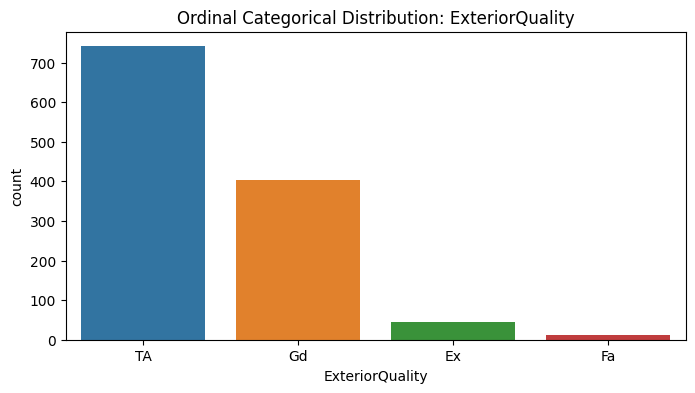

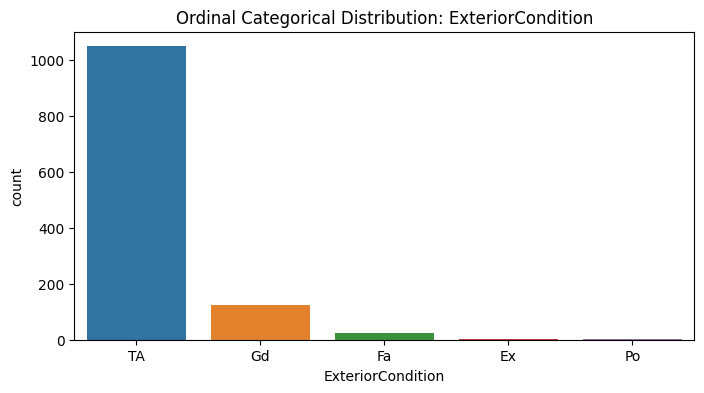

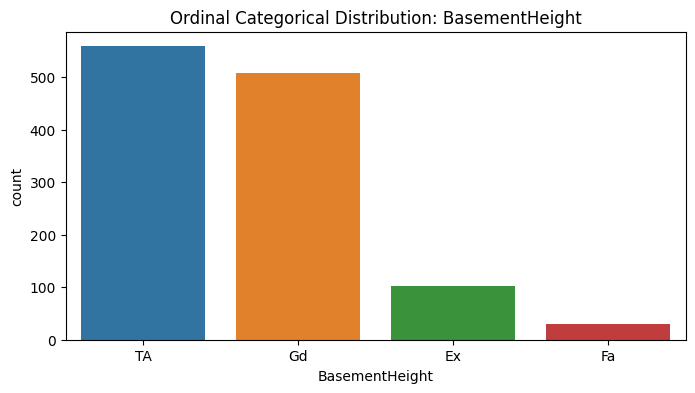

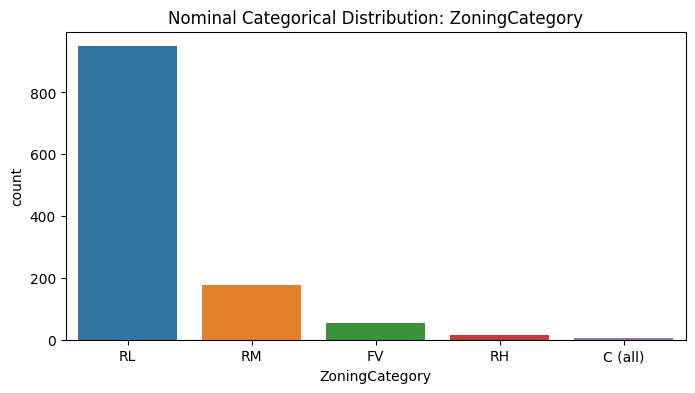

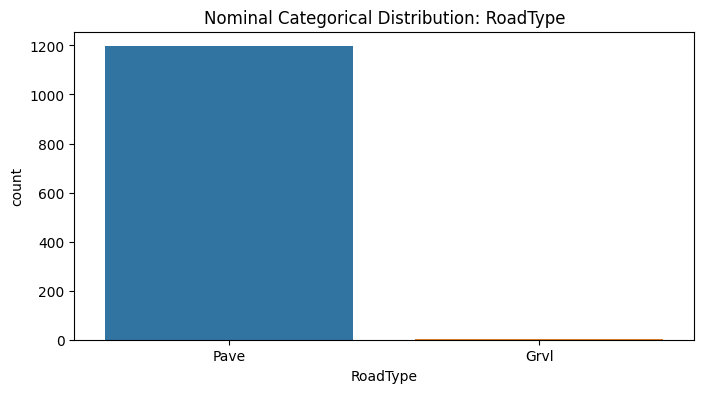

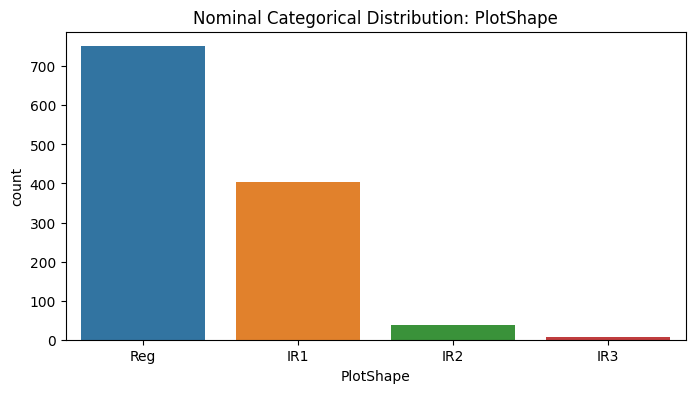

In [93]:
# Visualize original (pre-encoding) values for first few categorical features
cat_cols = [c for c in train.select_dtypes(include='object').columns if c not in ordinal_quality_cols + ordinal_exposure_cols]
ordinal_cat_cols = ordinal_quality_cols + ordinal_exposure_cols

# For ordinal columns, show their order and distribution
for col in ordinal_cat_cols[:3]:  # limit to a few for clarity
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, data=train, order=train[col].value_counts().index)
    plt.title(f'Ordinal Categorical Distribution: {col}')
    plt.show()

# For one-hot columns, show label distribution
for col in cat_cols[:3]:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, data=train, order=train[col].value_counts().index)
    plt.title(f'Nominal Categorical Distribution: {col}')
    plt.show()


In [94]:
# Only keep those columns that exist in train after dropping
ordinal_cat_cols_present = [c for c in ordinal_cat_cols if c in train.columns]
cat_cols_present = [c for c in cat_cols if c in train.columns]

sample_size = 12
ordinal_samples = train[ordinal_cat_cols_present][:sample_size]
cat_samples = train[cat_cols_present][:sample_size]

# Ordinal encoding visualization
ordinal_encoder = OrdinalEncoder(categories=[
    ['Po', 'TA', 'Fa', 'Gd', 'Ex'] if c != "BasementExposure" else ['No', 'Mn', 'Av', 'Gd']
    for c in ordinal_cat_cols_present
])
ordinal_encoded = ordinal_encoder.fit_transform(ordinal_samples)
df_ordinal = pd.DataFrame(ordinal_encoded, columns=ordinal_cat_cols_present)

print("Ordinal encoder example output:")
display(df_ordinal.head())

# One-hot encoding visualization
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
onehot_encoded = onehot_encoder.fit_transform(cat_samples)
onehot_feature_names = onehot_encoder.get_feature_names_out(cat_cols_present)
df_onehot = pd.DataFrame(onehot_encoded, columns=onehot_feature_names)

print("One-hot encoder example output (columns truncated):")
display(df_onehot.iloc[:,:12]) # display first 12 columns for brevity


Ordinal encoder example output:


ExteriorQuality  ExteriorCondition  BasementHeight  BasementCondition  \
0              3.0                1.0             3.0                1.0   
1              3.0                1.0             3.0                1.0   
2              1.0                1.0             1.0                3.0   
3              3.0                1.0             3.0                1.0   
4              4.0                1.0             4.0                1.0   

   HeatingQuality  KitchenQuality  BasementExposure  
0             3.0             3.0               2.0  
1             1.0             1.0               0.0  
2             1.0             1.0               2.0  
3             3.0             3.0               3.0  
4             4.0             4.0               0.0

One-hot encoder example output (columns truncated):


ZoningCategory_RL  ZoningCategory_RM  RoadType_Pave  PlotShape_IR1  \
0                 1.0                0.0            1.0            0.0   
1                 1.0                0.0            1.0            1.0   
2                 1.0                0.0            1.0            0.0   
3                 1.0                0.0            1.0            0.0   
4                 1.0                0.0            1.0            0.0   
5                 1.0                0.0            1.0            1.0   
6                 0.0                1.0            1.0            0.0   
7                 0.0                1.0            1.0            0.0   
8                 1.0                0.0            1.0            0.0   
9                 1.0                0.0            1.0            1.0   
10                1.0                0.0            1.0            0.0   
11                1.0                0.0            1.0            1.0   

    PlotShape_Reg  LandElevation_HLS  LandElevation_Low  LandElevation_Lvl  \
0             1.0                0.0                0.0                1.0   
1             0.0                0.0                0.0                1.0   
2             1.0                0.0                0.0                1.0   
3             1.0                0.0                1.0                0.0   
4             1.0                0.0                0.0                1.0   
5             0.0                0.0                0.0                1.0   
6             1.0                0.0                0.0                1.0   
7             1.0                0.0                0.0                1.0   
8             1.0                0.0                0.0                1.0   
9             0.0                0.0                0.0                1.0   
10            1.0                0.0                0.0                1.0   
11            0.0                1.0                0.0                0.0   

    UtilityAccess_AllPub  PlotConfiguration_Corner  PlotConfiguration_CulDSac  \
0                    1.0                       1.0                        0.0   
1                    1.0                       0.0                        0.0   
2                    1.0                       1.0                        0.0   
3                    1.0                       0.0                        0.0   
4                    1.0                       0.0                        0.0   
5                    1.0                       0.0                        1.0   
6                    1.0                       0.0                        0.0   
7                    1.0                       0.0                        0.0   
8                    1.0                       0.0                        0.0   
9                    1.0                       0.0                        0.0   
10                   1.0                       0.0                        0.0   
11                   1.0                       0.0                        0.0   

    PlotConfiguration_FR2  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  
5                     0.0  
6                     1.0  
7                     0.0  
8                     0.0  
9                     0.0  
10                    0.0  
11                    0.0

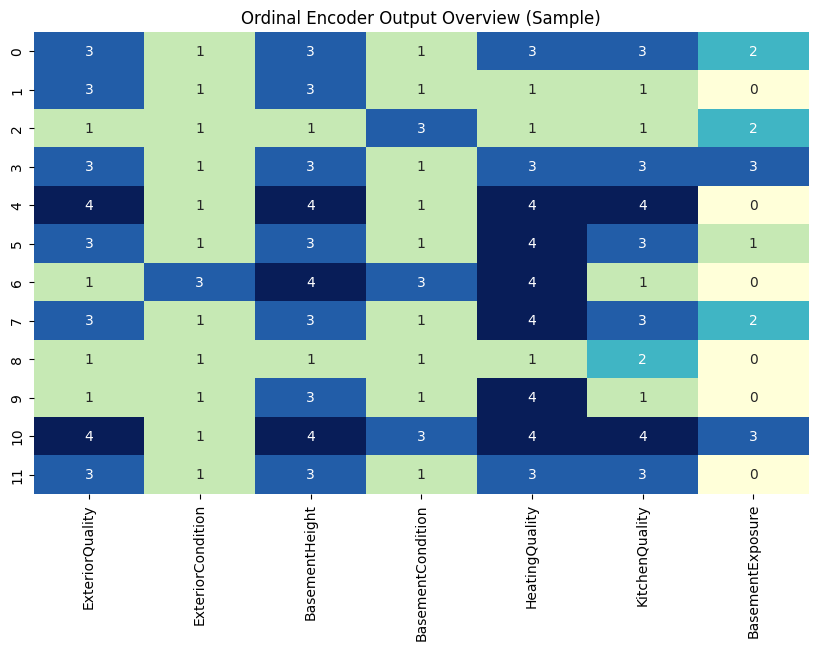

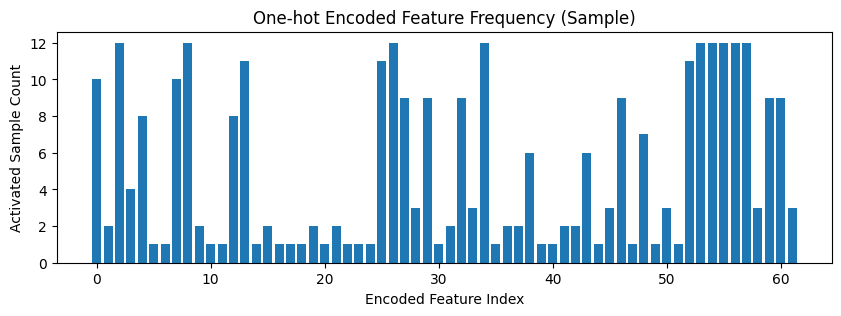

In [95]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(df_ordinal, cmap="YlGnBu", annot=True, cbar=False)
plt.title("Ordinal Encoder Output Overview (Sample)")
plt.show()

plt.figure(figsize=(10, 3))
plt.bar(range(df_onehot.shape[1]), df_onehot.sum(axis=0))
plt.title("One-hot Encoded Feature Frequency (Sample)")
plt.xlabel("Encoded Feature Index")
plt.ylabel("Activated Sample Count")
plt.show()


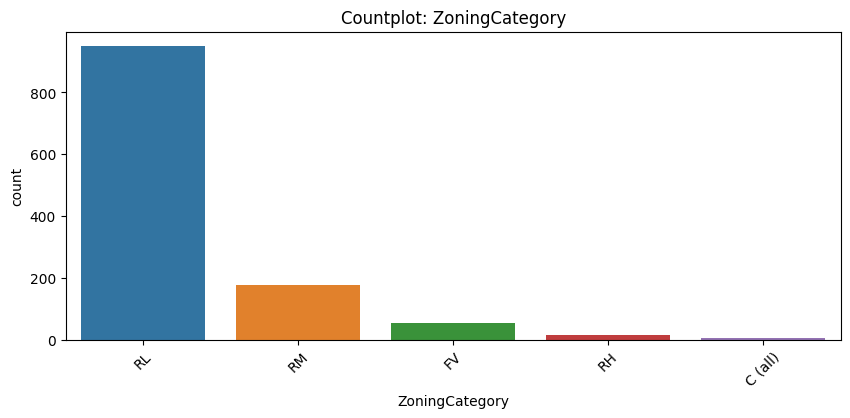

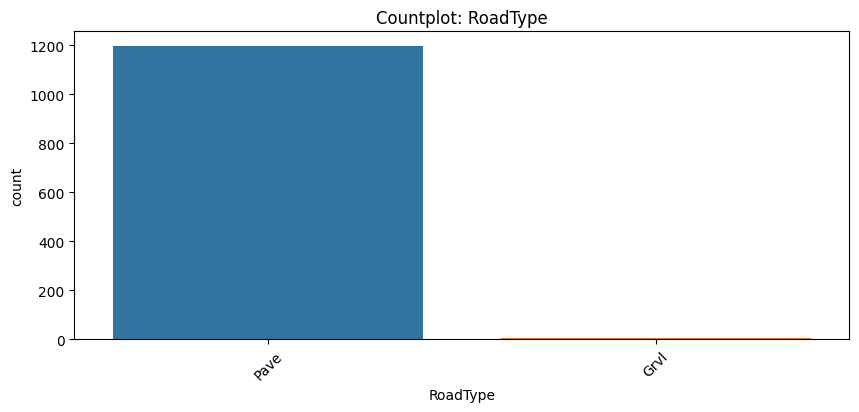

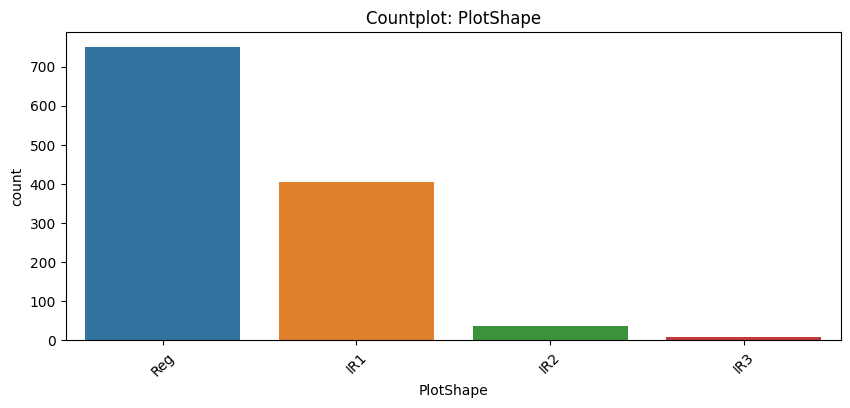

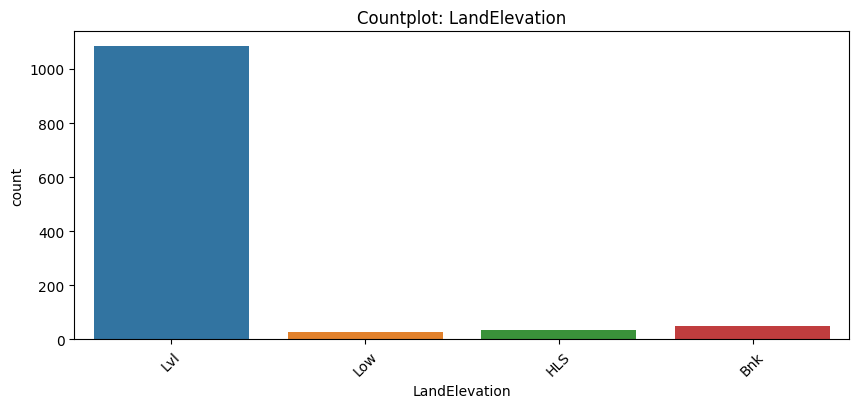

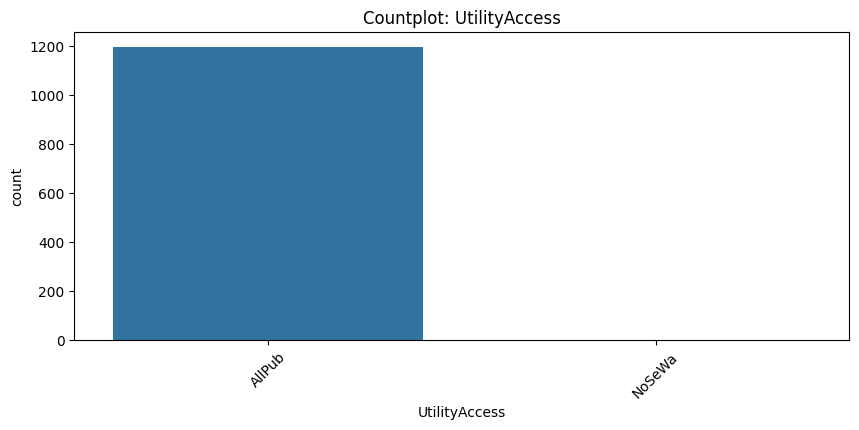

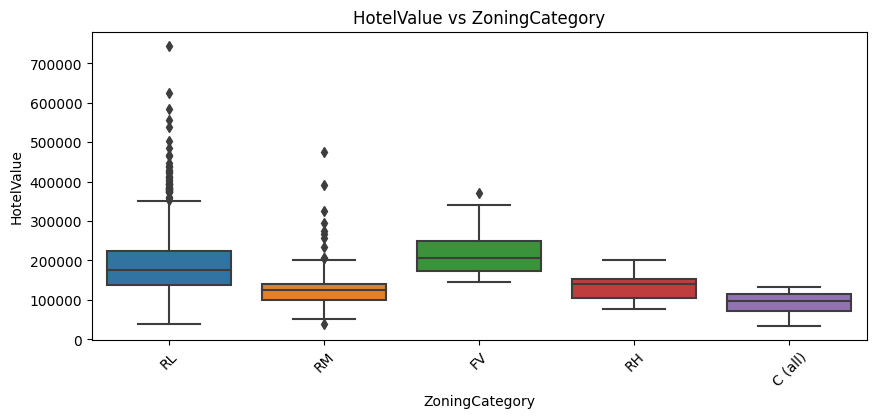

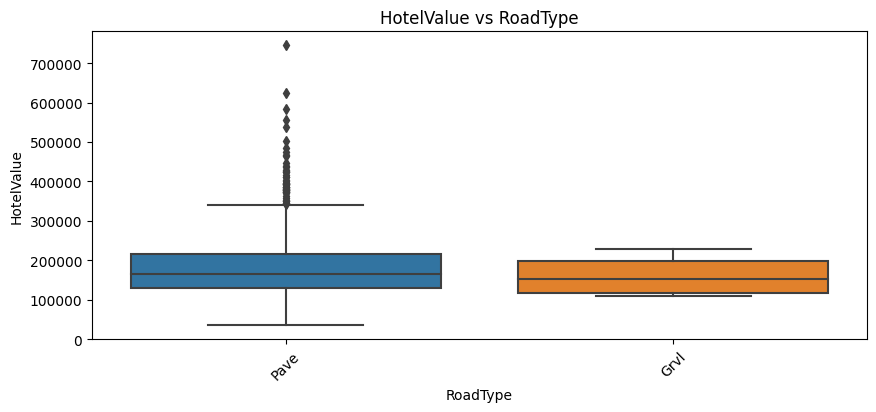

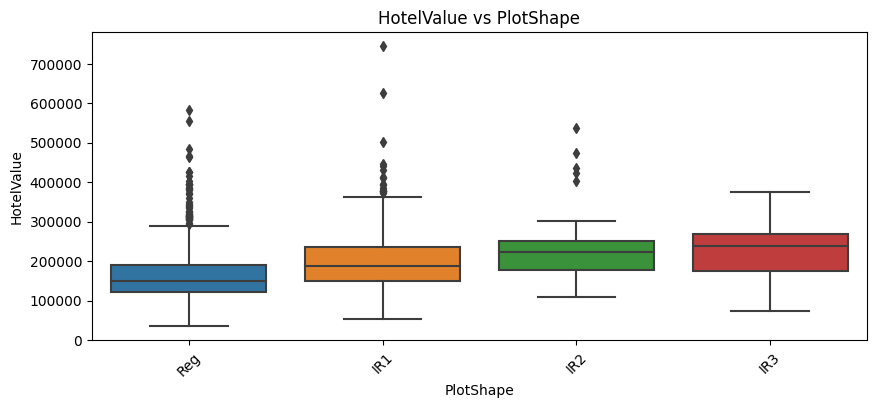

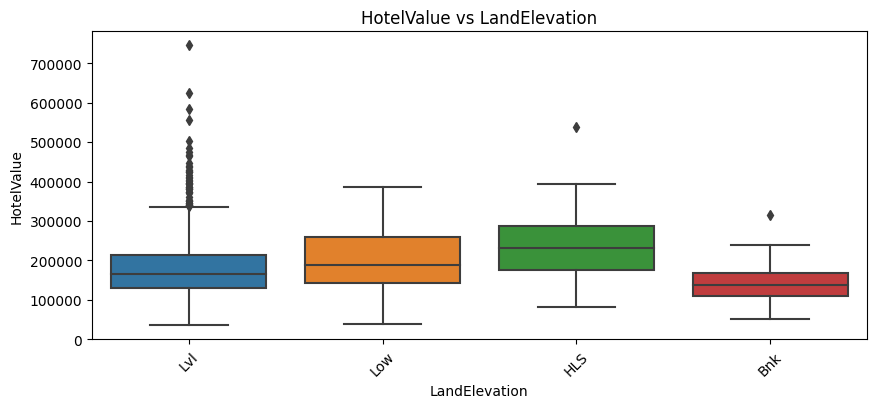

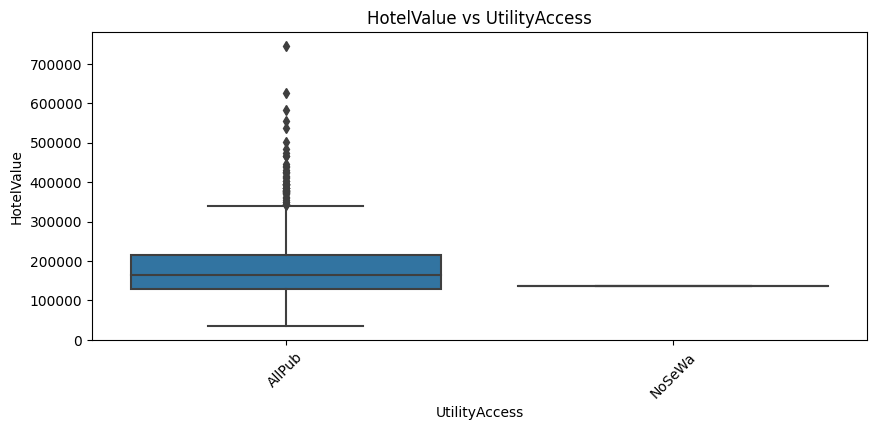

In [96]:
cat_columns = train.select_dtypes('object').columns

# Countplots (distribution of categories in train)
for col in cat_columns[:5]:  # Show the first 5 for brevity; extend as needed
    plt.figure(figsize=(10,4))
    sns.countplot(x=col, data=train)
    plt.xticks(rotation=45)
    plt.title(f"Countplot: {col}")
    plt.show()

# Boxplots (target vs categorical feature)
for col in cat_columns[:5]:  # As above
    plt.figure(figsize=(10,4))
    sns.boxplot(x=col, y='HotelValue', data=train)
    plt.title(f"HotelValue vs {col}")
    plt.xticks(rotation=45)
    plt.show()


In [97]:
#=== Checking Columns with less amount of null values ===
print("Training data columns with low nulls:", less_null_cols)
print("Testing data columns with low nulls:", less_null_cols_test)
print("="*80)

# Function to inspect a column safely
def inspect_column(df, col):
    missing_count = df[col].isna().sum()
    missing_pct = missing_count / len(df) * 100
    
    print(f"Column: {col}")
    print(f"Type: {'Categorical' if df[col].dtype=='object' else 'Numeric'}")
    print(f"Missing: {missing_count} ({missing_pct:.3f}%)")
    
    if df[col].dtype == 'object':
        # Include NaN explicitly
        print("Value counts (including NaN):")
        print(df[col].value_counts(dropna=False))
    else:
        print("Descriptive stats (numeric):")
        print(df[col].describe())
    print("-"*50)

# Inspect training data
print("TRAINING DATA:")
for col in less_null_cols:
    inspect_column(train, col)

# Inspect testing data
print("TESTING DATA:")
for col in less_null_cols_test:
    inspect_column(test, col)


Training data columns with low nulls: Index(['FacadeArea', 'ElectricalSystem'], dtype='object')
Testing data columns with low nulls: Index(['FacadeArea'], dtype='object')
TRAINING DATA:
Column: FacadeArea
Type: Numeric
Missing: 0 (0.000%)
Descriptive stats (numeric):
count    1200.000000
mean      102.839167
std       172.019647
min        -1.000000
25%         0.000000
50%         0.000000
75%       165.250000
max      1378.000000
Name: FacadeArea, dtype: float64
--------------------------------------------------
Column: ElectricalSystem
Type: Categorical
Missing: 0 (0.000%)
Value counts (including NaN):
ElectricalSystem
SBrkr    1103
FuseA      70
FuseF      24
FuseP       3
Name: count, dtype: int64
--------------------------------------------------
TESTING DATA:
Column: FacadeArea
Type: Numeric
Missing: 0 (0.000%)
Descriptive stats (numeric):
count     260.000000
mean      104.369231
std       216.842599
min        -1.000000
25%         0.000000
50%         0.000000
75%       148.0

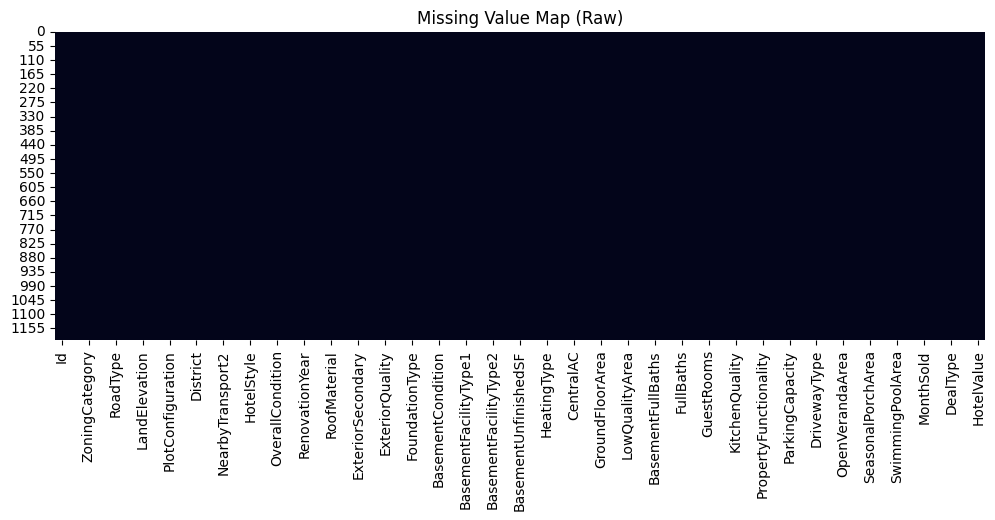

In [98]:
# Visualize % missingness (heatmap style)
plt.figure(figsize=(12,4))
sns.heatmap(train.isnull(), cbar=False)
plt.title("Missing Value Map (Raw)")
plt.show()


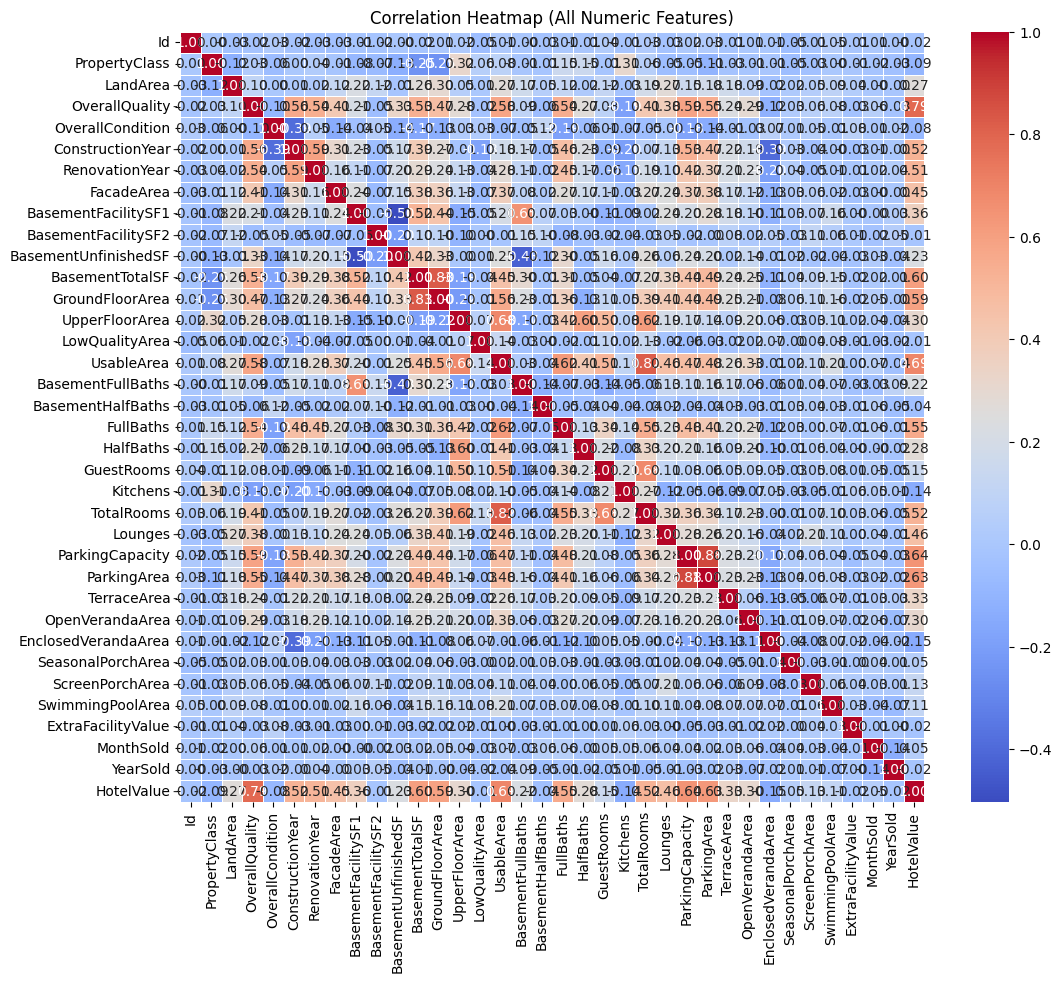

In [99]:
numeric_data = train.select_dtypes(include=np.number)
corr_matrix = numeric_data.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap (All Numeric Features)")
plt.show()


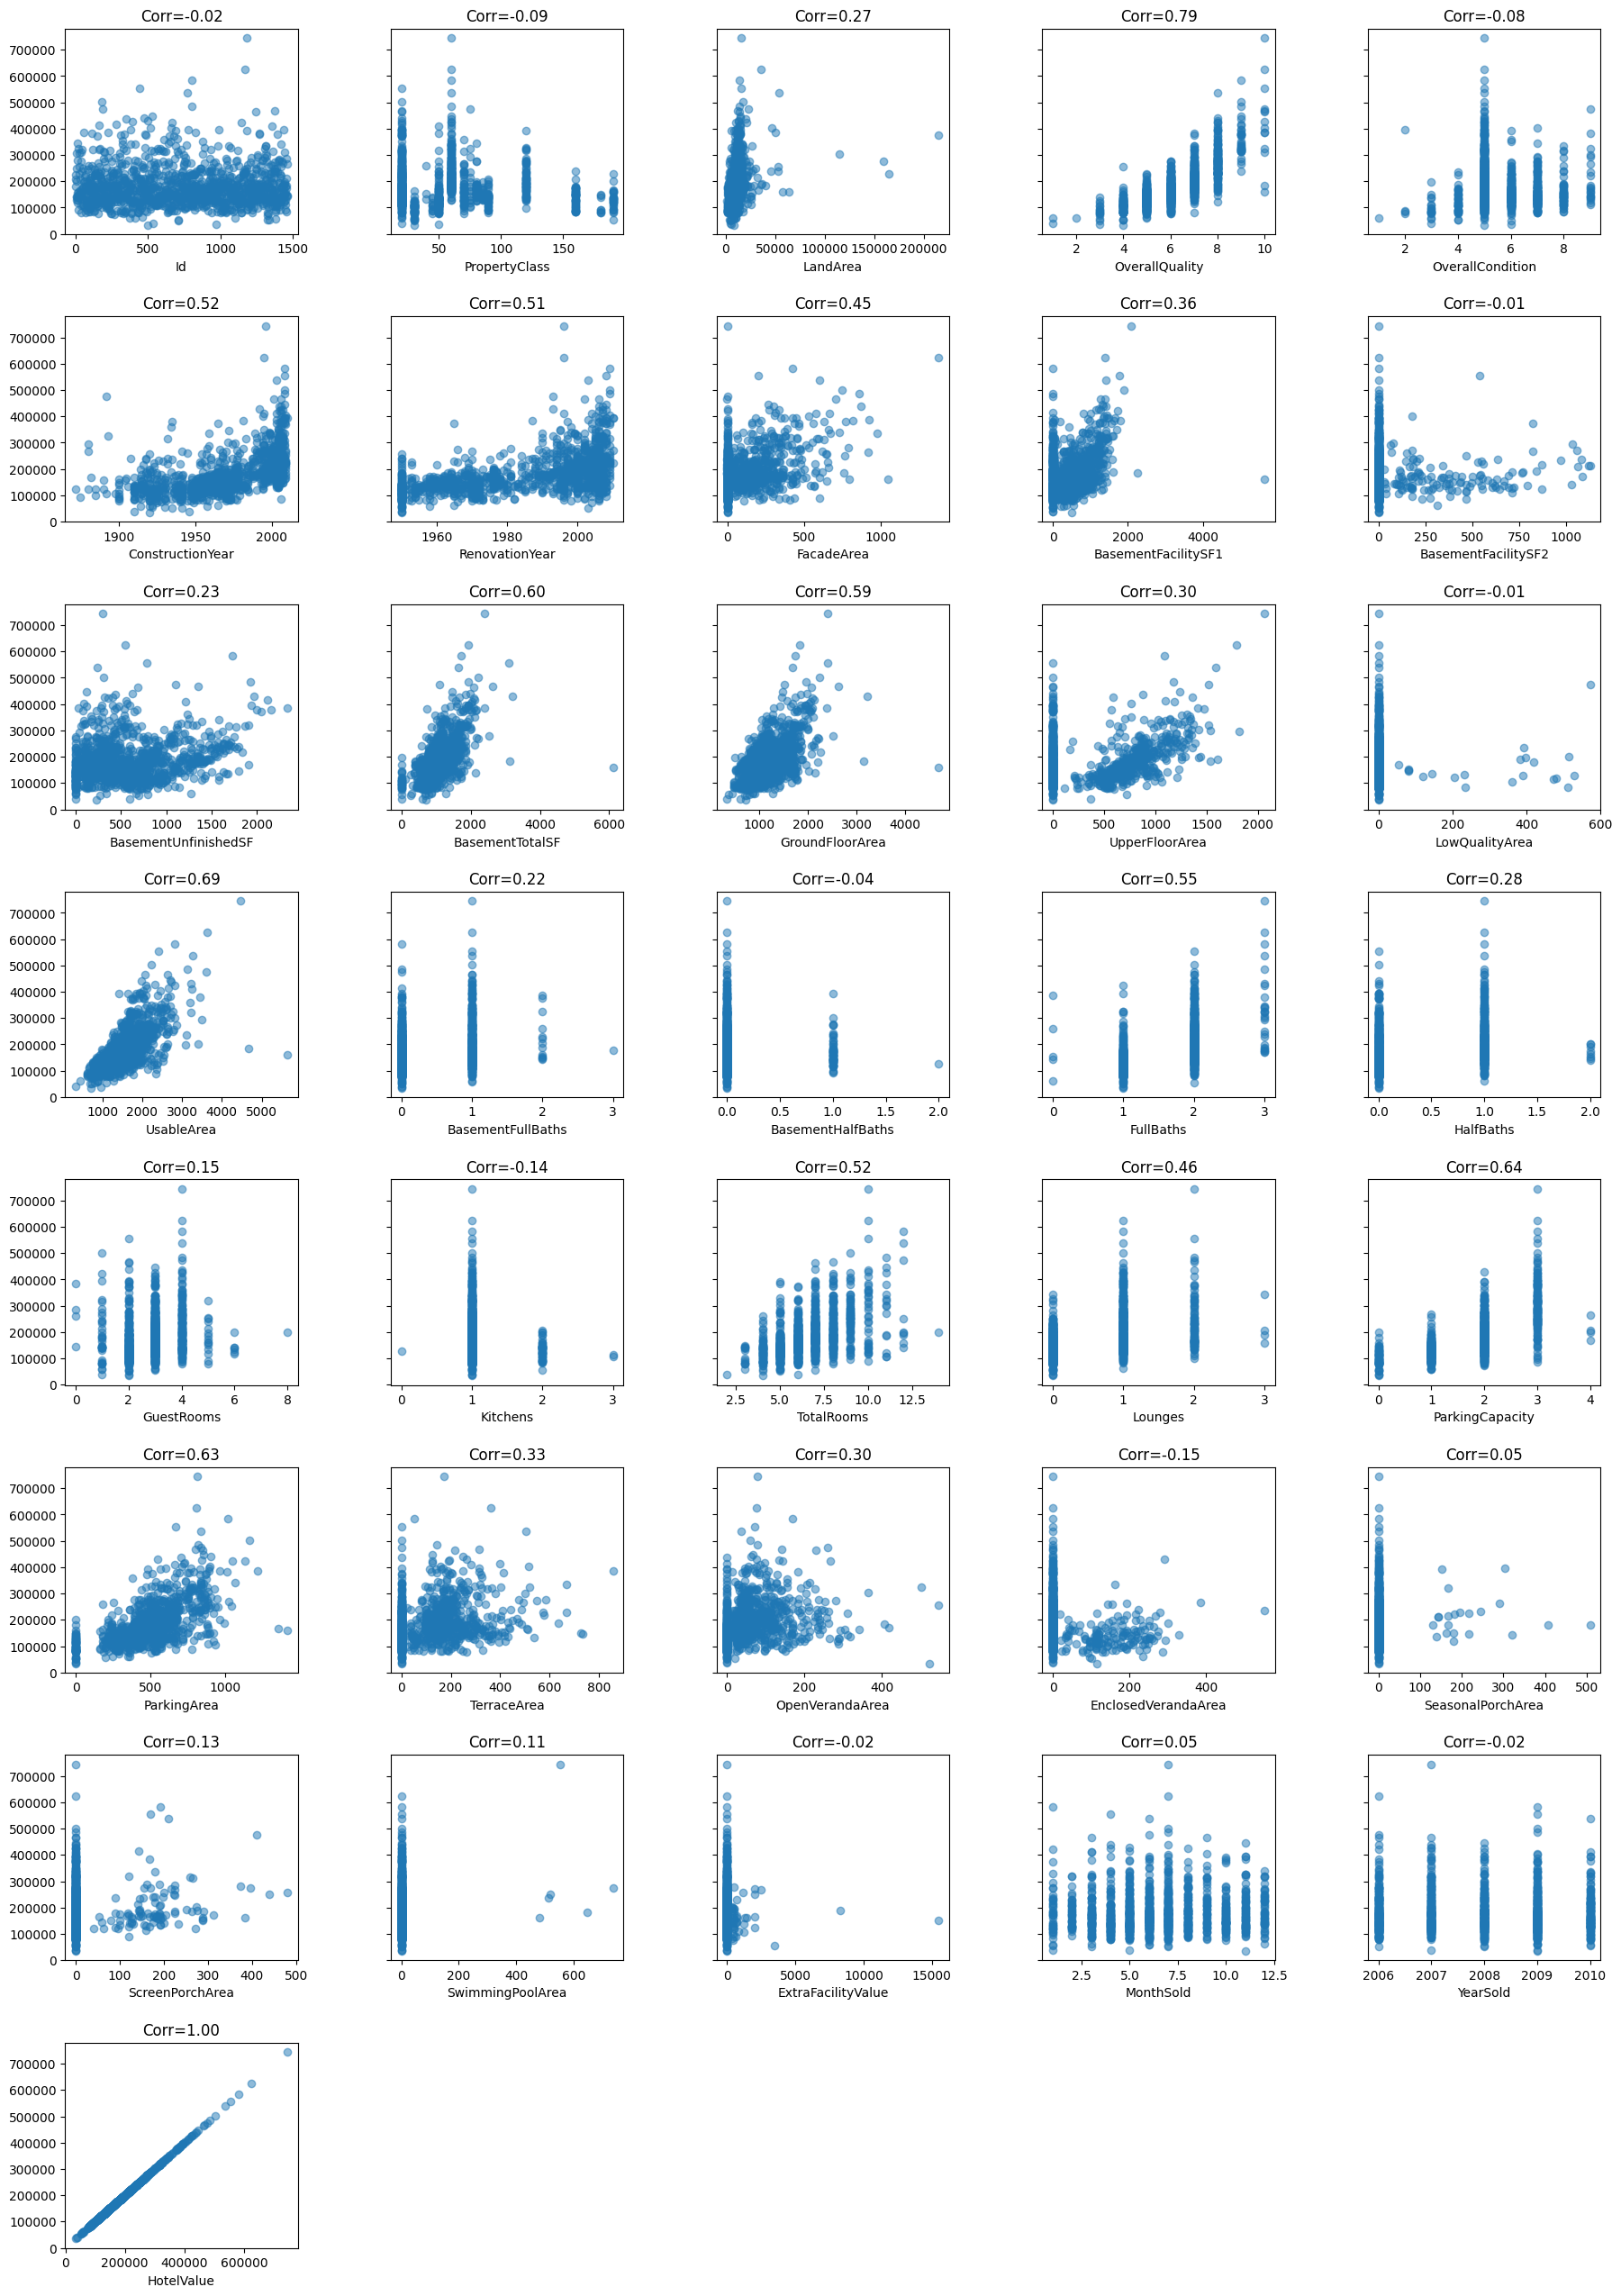

In [100]:
num_columns = numeric_data.columns
corr_to_value = numeric_data.corr()['HotelValue']

n_cols = 5
n_rows = int(np.ceil(len(num_columns) / n_cols))

fig, ax_arr = plt.subplots(n_rows, n_cols, figsize=(22, n_rows*4), sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for j in range(n_rows):
    for i in range(n_cols):
        idx = i + j*n_cols
        ax = ax_arr[j, i] if n_rows > 1 else ax_arr[i]
        if idx < len(num_columns):
            ax.scatter(train[num_columns[idx]], train['HotelValue'], alpha=0.5)
            ax.set_xlabel(num_columns[idx])
            ax.set_title(f"Corr={corr_to_value[num_columns[idx]]:.2f}")
        else:
            ax.axis('off')
plt.show()


### Outlier detection

In [101]:
'''
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_test = test.select_dtypes(include=[np.number]).columns.tolist()

class OutlierHandler:
    def __init__(self, col):
        q1 = col.quantile(0.25)
        q3 = col.quantile(0.75)
        iqr = q3 - q1
        self.lower = q1 - 1.5*iqr
        self.upper = q3 + 1.5*iqr
    def cap(self, val):
        return min(max(val, self.lower), self.upper)

for col in numeric_cols:
    handler = OutlierHandler(train[col])
    train[col] = train[col].apply(handler.cap)
    
for col in numeric_cols_test:
    if col in train.columns:
        handler = OutlierHandler(train[col])
        test[col] = test[col].apply(handler.cap)
'''

'\nnumeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()\nnumeric_cols_test = test.select_dtypes(include=[np.number]).columns.tolist()\n\nclass OutlierHandler:\n    def __init__(self, col):\n        q1 = col.quantile(0.25)\n        q3 = col.quantile(0.75)\n        iqr = q3 - q1\n        self.lower = q1 - 1.5*iqr\n        self.upper = q3 + 1.5*iqr\n    def cap(self, val):\n        return min(max(val, self.lower), self.upper)\n\nfor col in numeric_cols:\n    handler = OutlierHandler(train[col])\n    train[col] = train[col].apply(handler.cap)\n    \nfor col in numeric_cols_test:\n    if col in train.columns:\n        handler = OutlierHandler(train[col])\n        test[col] = test[col].apply(handler.cap)\n'

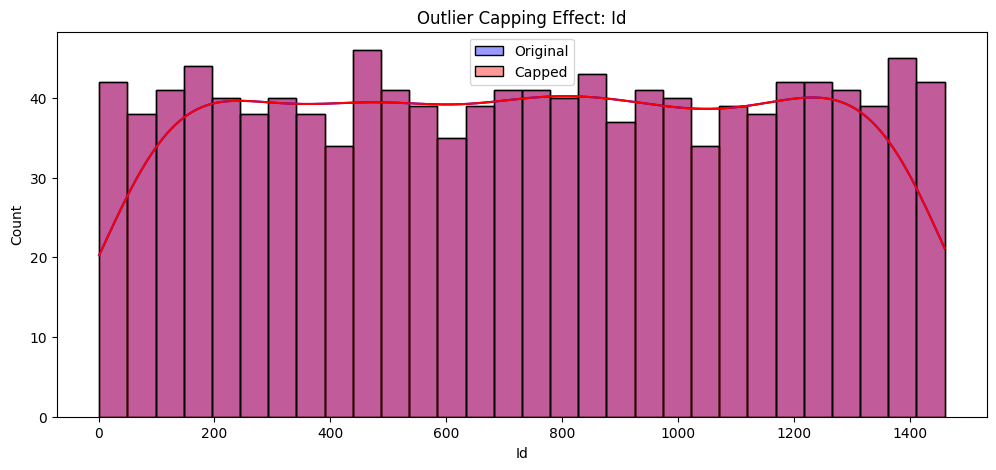

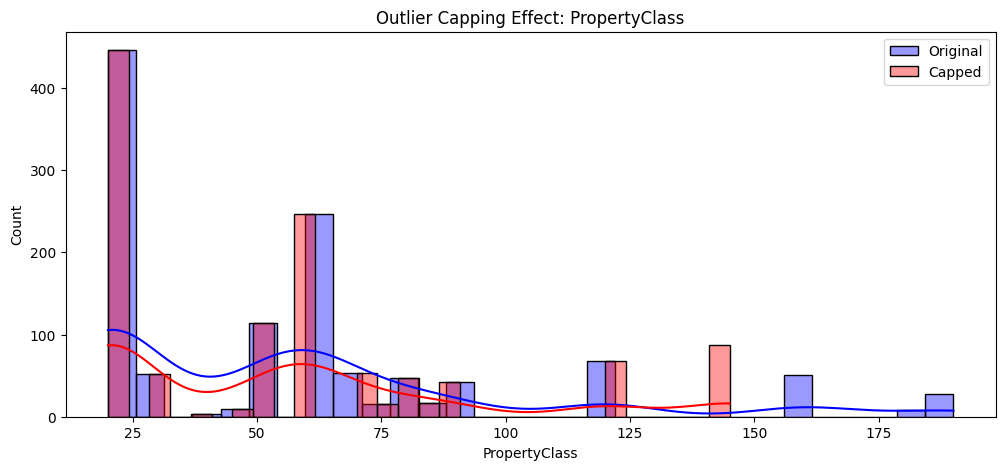

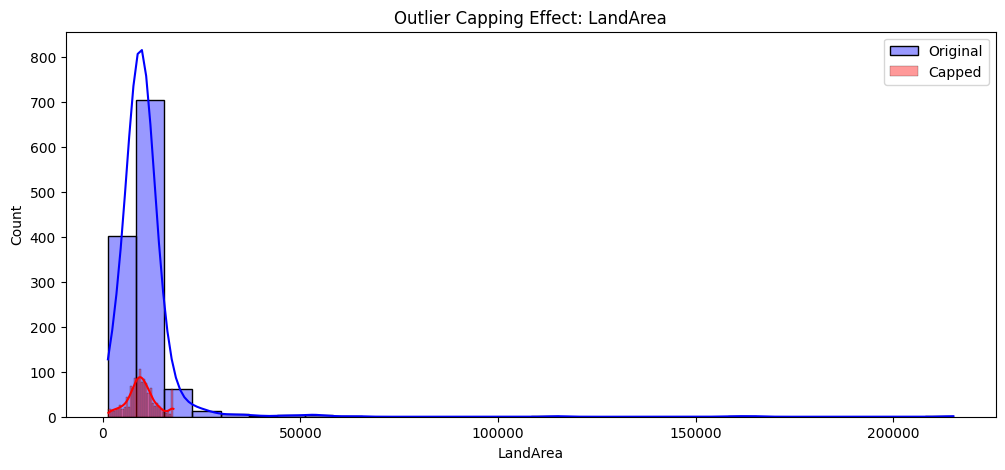

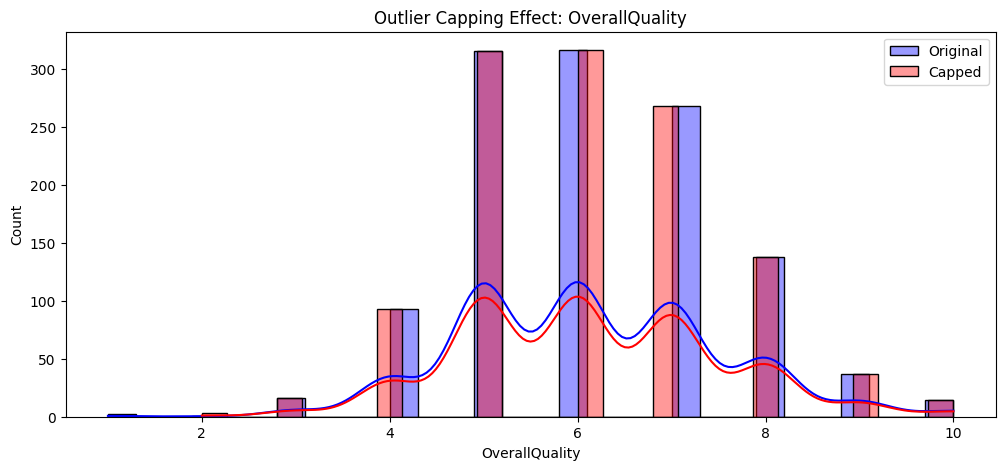

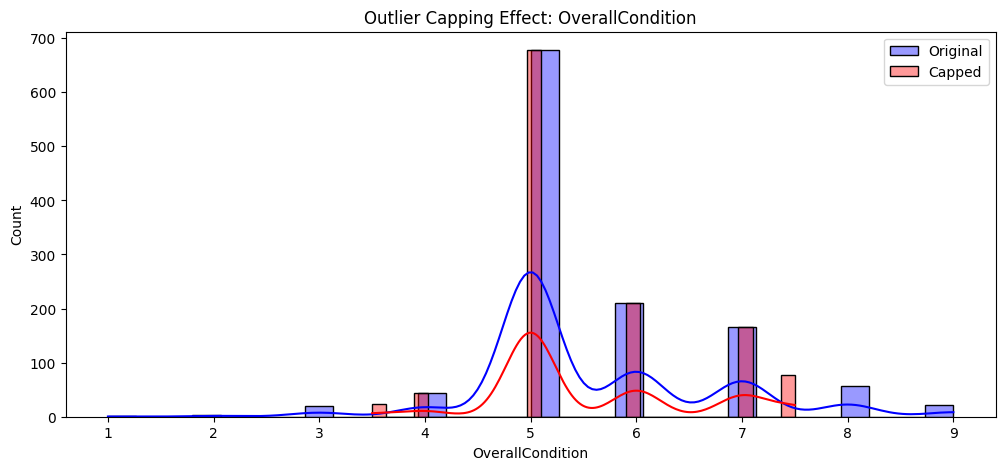

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select key numeric columns for demonstration (you can show all, or just a few)
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
example_cols = numeric_cols[:5]  # or ['HotelValue',...] or your top outlier-prone columns

# Outlier capping function (same logic, but for visualization ONLY)
def cap_outliers(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return col.clip(lower, upper)

# Plot before and after outlier handling for each feature
for col in example_cols:
    capped = cap_outliers(train[col])
    plt.figure(figsize=(12,5))
    sns.histplot(train[col], bins=30, color='blue', alpha=0.4, label='Original', kde=True)
    sns.histplot(capped, bins=30, color='red', alpha=0.4, label='Capped', kde=True)
    plt.title(f"Outlier Capping Effect: {col}")
    plt.xlabel(col)
    plt.legend()
    plt.show()


### Standardisation

In [103]:

numeric_cols = [c for c in train.select_dtypes(include=[np.number]).columns if c not in ['Id', 'HotelValue']]
common_numeric_cols = [c for c in numeric_cols if c in test.columns]

scaler = StandardScaler()
train[common_numeric_cols] = scaler.fit_transform(train[common_numeric_cols])
test[common_numeric_cols] = scaler.transform(test[common_numeric_cols])


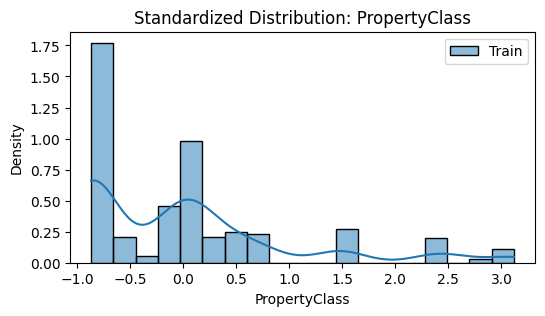

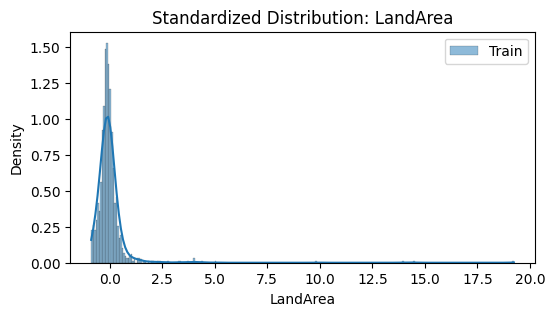

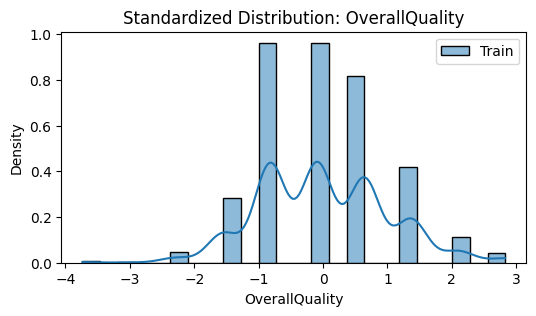

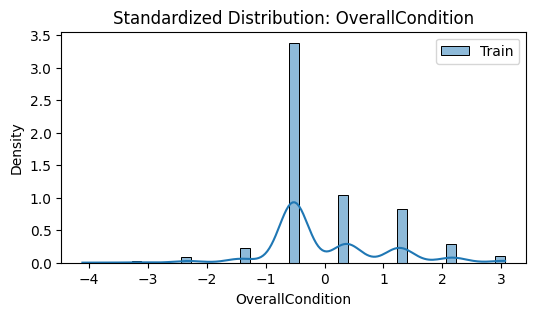

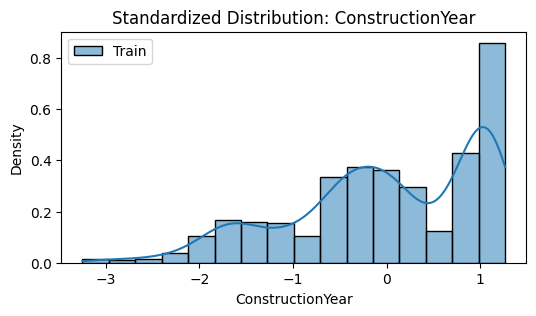

In [104]:
for col in common_numeric_cols[:5]:  # Use all or key numeric columns
    plt.figure(figsize=(6,3))
    sns.histplot(train[col], label='Train', kde=True, stat="density")
    plt.title(f"Standardized Distribution: {col}")
    plt.legend()
    plt.show()


## EDA

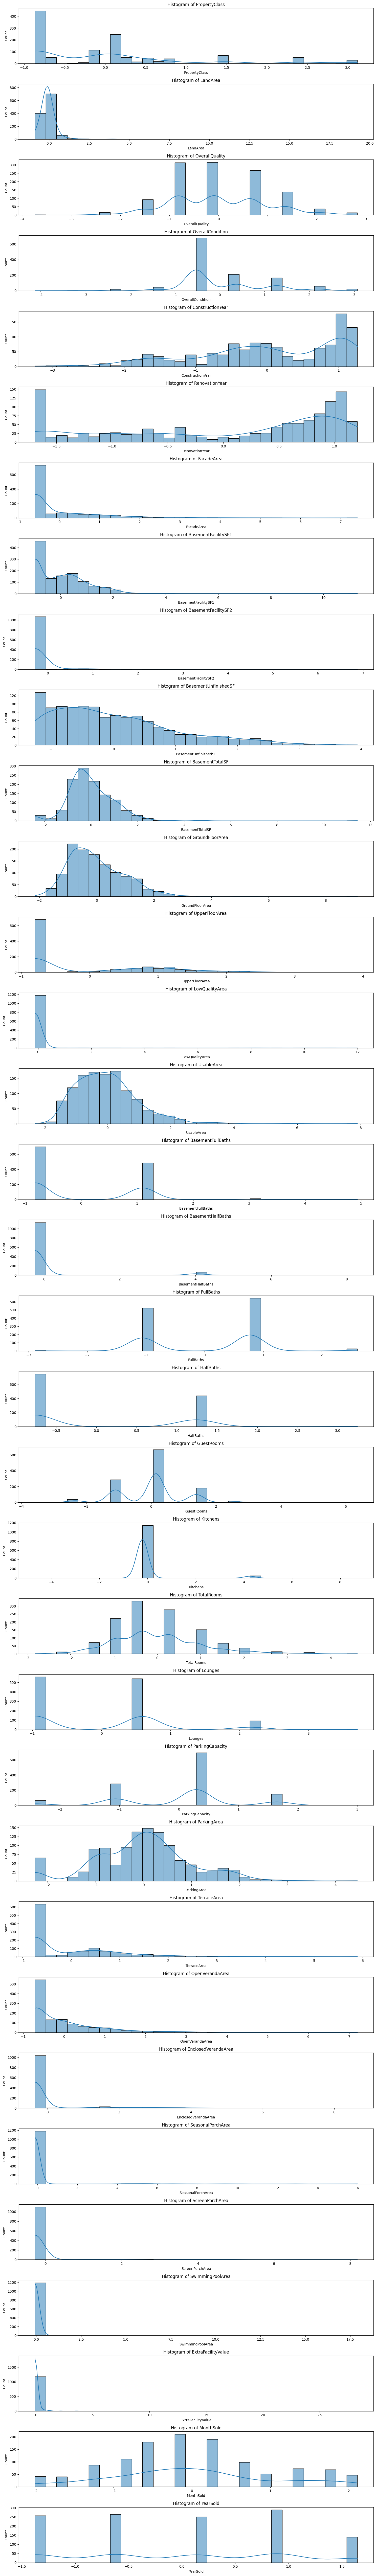

In [105]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(15, len(common_numeric_cols)*3))
for i, col in enumerate(common_numeric_cols):
    plt.subplot(len(common_numeric_cols), 1, i+1)
    sns.histplot(train[col], kde=True, bins=30)
    plt.title(f"Histogram of {col}")
plt.tight_layout()
plt.show()

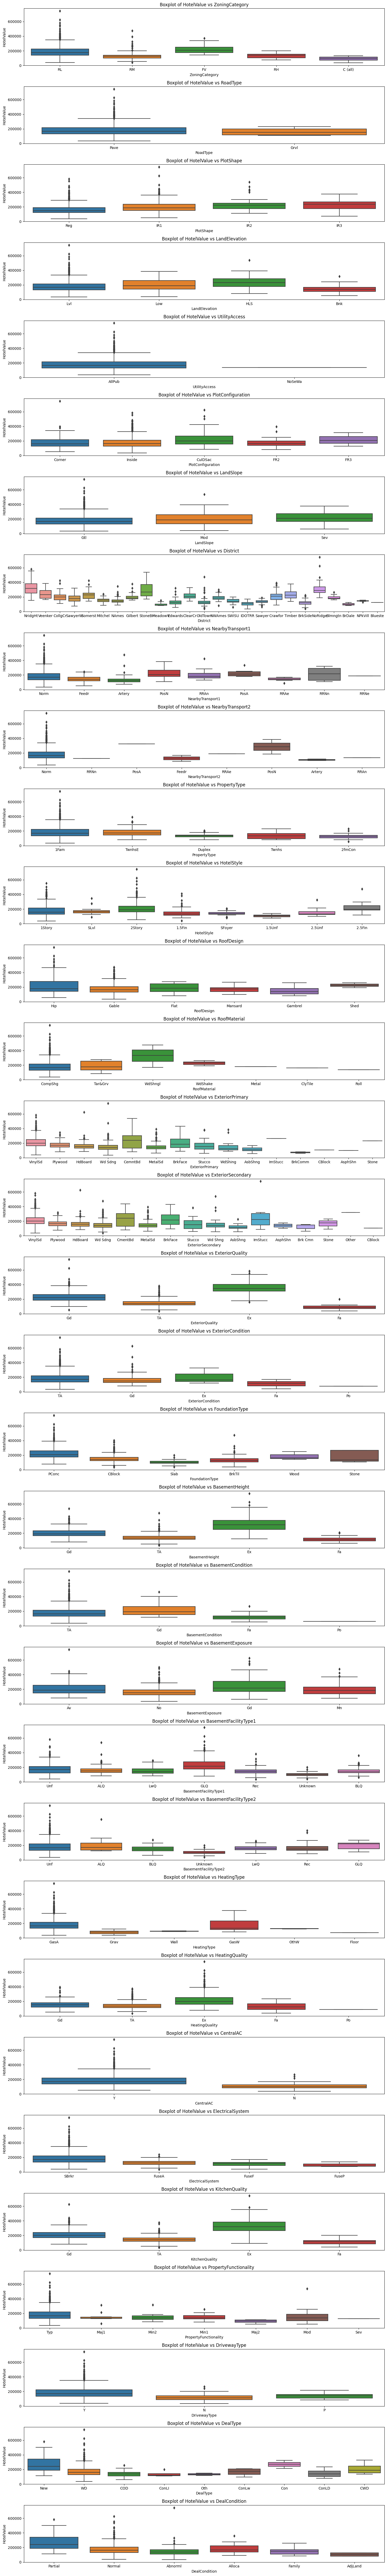

In [106]:
categorical_cols_final = train.select_dtypes(include=['object']).columns.tolist()
plt.figure(figsize=(15, len(categorical_cols_final)*3))
for i, col in enumerate(categorical_cols_final):
    plt.subplot(len(categorical_cols_final), 1, i+1)
    sns.boxplot(x=train[col], y=train['HotelValue'])
    plt.title(f"Boxplot of HotelValue vs {col}")
plt.tight_layout()
plt.show()

Saving the processed Datasets

In [107]:
train.to_csv("train_processed.csv", index=False)
test.to_csv("test_processed.csv", index=False)

print("Preprocessing complete!")
print("Processed train shape:", train.shape)
print("Processed test shape:", test.shape)

Preprocessing complete!
Processed train shape: (1200, 69)
Processed test shape: (260, 68)


Testing the preprocessed data to see how similarly the test and train data are processed

Columns in train not in test: {'HotelValue'}
Columns in test not in train: set()
Column 'RoofMaterial' has unseen test values: {'Membran'}
Column 'ElectricalSystem' has unseen test values: {'Mix'}

Numeric column means (train vs test):
Id: train mean=733.330, test mean=717.438
PropertyClass: train mean=0.000, test mean=-0.015
LandArea: train mean=-0.000, test mean=-0.077
OverallQuality: train mean=0.000, test mean=-0.098
OverallCondition: train mean=0.000, test mean=-0.036
ConstructionYear: train mean=-0.000, test mean=-0.009
RenovationYear: train mean=-0.000, test mean=-0.047
FacadeArea: train mean=0.000, test mean=0.009
BasementFacilitySF1: train mean=0.000, test mean=-0.045
BasementFacilitySF2: train mean=-0.000, test mean=0.065
BasementUnfinishedSF: train mean=-0.000, test mean=-0.041
BasementTotalSF: train mean=-0.000, test mean=-0.065
GroundFloorArea: train mean=-0.000, test mean=-0.096
UpperFloorArea: train mean=0.000, test mean=-0.038
LowQualityArea: train mean=0.000, test mean

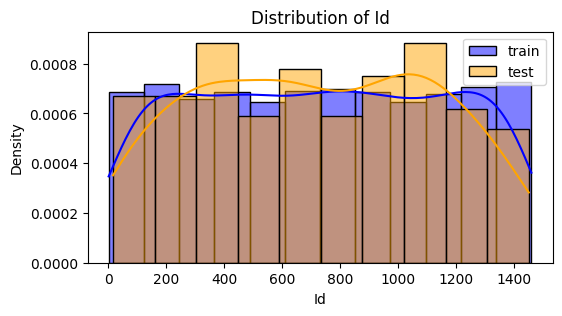

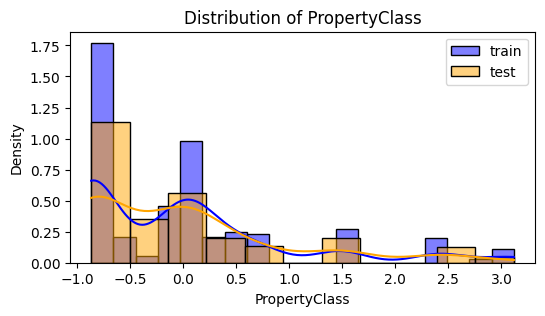

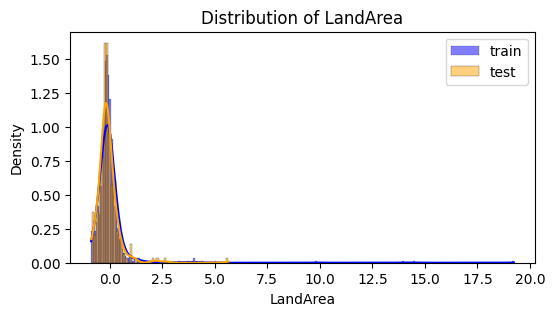

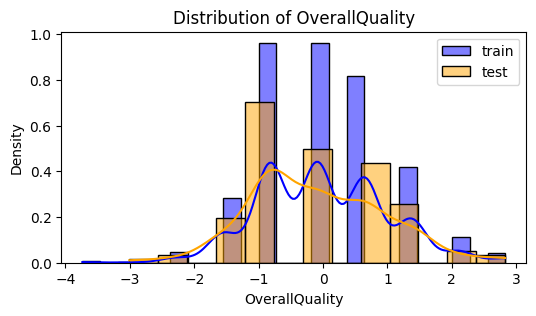

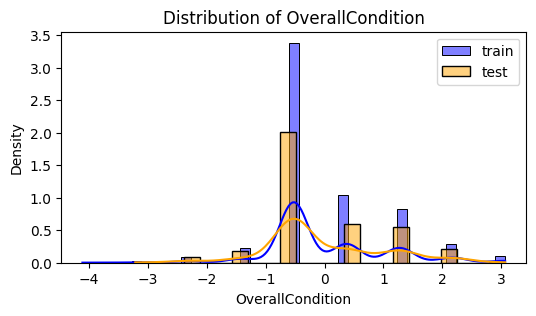

<Figure size 600x300 with 0 Axes>

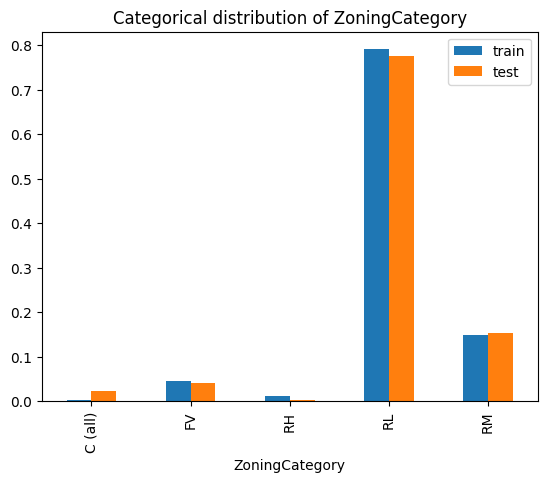

<Figure size 600x300 with 0 Axes>

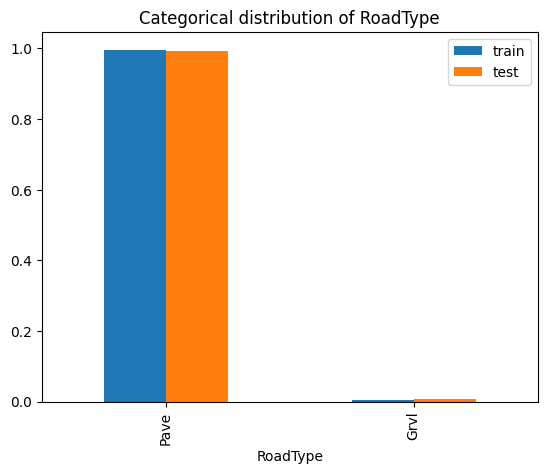

<Figure size 600x300 with 0 Axes>

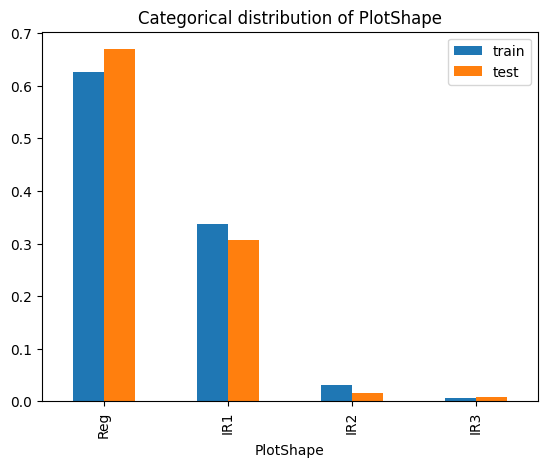

<Figure size 600x300 with 0 Axes>

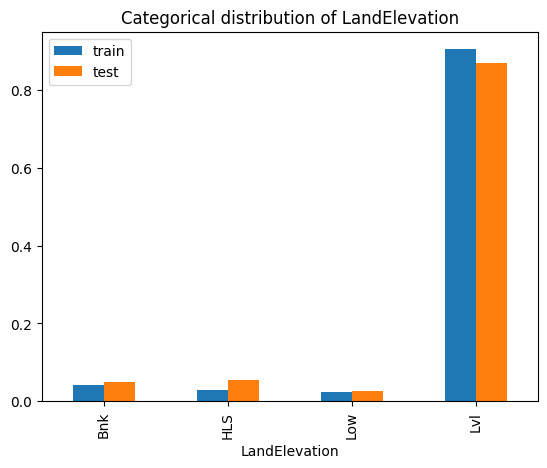

<Figure size 600x300 with 0 Axes>

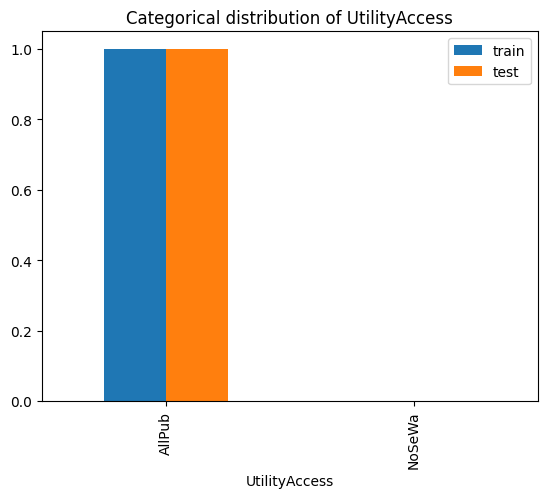

In [108]:

# =======================
#  Check columns
# =======================
train_cols = set(train.columns)
test_cols = set(test.columns)

print("Columns in train not in test:", train_cols - test_cols)
print("Columns in test not in train:", test_cols - train_cols)

# =======================
# Check categorical values
# =======================
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    if col in test.columns:
        train_vals = set(train[col].unique())
        test_vals = set(test[col].unique())
        unseen = test_vals - train_vals
        if unseen:
            print(f"Column '{col}' has unseen test values:", unseen)

# =======================
# Check numeric scaling
# =======================
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
common_numeric_cols = [col for col in numeric_cols if col in test.columns]

print("\nNumeric column means (train vs test):")
for col in common_numeric_cols:
    print(f"{col}: train mean={train[col].mean():.3f}, test mean={test[col].mean():.3f}")

# =======================
#  Check missing values
# =======================
print("\nTotal missing values:")
print("Train:", train.isna().sum().sum())
print("Test:", test.isna().sum().sum())

# =======================
#  Plot numeric distributions (optional)
# =======================
for col in common_numeric_cols[:5]:  # check first 5 numeric features
    plt.figure(figsize=(6,3))
    sns.histplot(train[col], color='blue', label='train', kde=True, stat="density")
    sns.histplot(test[col], color='orange', label='test', kde=True, stat="density")
    plt.title(f"Distribution of {col}")
    plt.legend()
    plt.show()

# =======================
# Optional: check categorical distributions
# =======================
for col in categorical_cols[:5]:  # check first 5 categorical features
    if col in test.columns:
        plt.figure(figsize=(6,3))
        train_counts = train[col].value_counts(normalize=True)
        test_counts = test[col].value_counts(normalize=True)
        df_plot = pd.DataFrame({'train': train_counts, 'test': test_counts}).fillna(0)
        df_plot.plot(kind='bar')
        plt.title(f"Categorical distribution of {col}")
        plt.show()